# Deep Learning for Time Series Forecasting : Introduction to RNN and LSTM

In this notebook, we will learn how to implement a recurrent neural network from scratch using Pytorch. We will also see how to use LSTM to solve a multivariate time series forecasting problem.
The task is to forecast the next day consumption of power of power given the passed day data.

## 1. RNN from scratch in an univariate time series forecasting problem with a recursive approach

In [1]:
# import gdown

# url = "https://drive.google.com/drive/folders/10fxlNGVm3xIJQLB958CU56T6UTGp_md0?usp=drive_link"
# gdown.download_folder(url, quiet=True, use_cookies=False)

#### Import and load data

In [ ]:
!pip install pytorch-forecasting

In [3]:
# Import external modules
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Data loader
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

pd.options.plotting.backend = "plotly"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
processed_data_path = "/content/drive/MyDrive" # "data/processed/"
processed_filename = os.path.join(processed_data_path, "clean-data-consolidated.csv")
data = pd.read_csv(processed_filename)
# uncomment to use 20% of the data
data = data.iloc[int(len(data)*0.8):]
# Convert 'Date - Heure' to datetime and set as index
data["Date - Heure"] = pd.to_datetime(data["Date - Heure"])
data.set_index("Date - Heure", inplace=True)

# select only "Île-de-France"
data_iledefrance = data[data["Région"] == "Île-de-France"]
# Focusing on the 'Consommation brute électricité (MW) - RTE' column
ts_data = data_iledefrance["Consommation brute électricité (MW) - RTE"]

In [6]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Preprocessing of the data

The first requirement is to create the sequences. In a first approach we will use a the last 24 hours to predict the next hour. We will then use the Recursive Multi-Step Forecasting strategy to predict the next 24 hours.

In [7]:
# Normalizing the data
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))


# Function to create sequences
def create_sequences_rec(data, seq_length):
    """Create sequences of seq_length from data. And return X and y with y being the next value after X."""
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length] # TODO
        y = data[i+seq_length] # TODO
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Defining the sequence length (number of hours to use for prediction)
seq_length = 24  # using last 24 hours to predict the next hour
X, y = create_sequences_rec(ts_scaled, seq_length)

# Splitting the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

test_data = TensorDataset(X_test, y_test)

# shuffle the training data without dataloader
indices = torch.randperm(len(X_train))
X_train = X_train[indices]
y_train = y_train[indices]
train_data = TensorDataset(X_train, y_train)

print(f"Number of training samples: {len(train_data)}")
print(f"Number of test samples: {len(test_data)}")

Number of training samples: 8394
Number of test samples: 2099


### Model definition

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2output = nn.Linear(input_size + hidden_size, output_size)

    def forward(self, x, hidden_state):
        combined = torch.cat((x, hidden_state), 1) # TODO
        hidden = F.relu(self.in2hidden(combined)) # TODO
        output = self.in2output(combined) # TODO
        return output, hidden

    def initHidden(self):
        return nn.init.kaiming_uniform_(
            torch.empty(1, self.hidden_size)
        )  # Add batch_size as the first dimension


# Instantiate the model
input_size = 1
hidden_size = 64
output_size = 1
model = RNN(input_size, hidden_size, output_size).to(device)

### Training

Epochs:  10%|█         | 1/10 [01:19<11:52, 79.17s/it]

Epoch 1/10, Train Loss: 0.0102, Test Loss: 0.0040


Epochs:  20%|██        | 2/10 [02:29<09:50, 73.79s/it]

Epoch 2/10, Train Loss: 0.0025, Test Loss: 0.0021


Epochs:  30%|███       | 3/10 [03:37<08:20, 71.51s/it]

Epoch 3/10, Train Loss: 0.0017, Test Loss: 0.0017


Epochs:  40%|████      | 4/10 [04:45<07:00, 70.12s/it]

Epoch 4/10, Train Loss: 0.0013, Test Loss: 0.0013


Epochs:  50%|█████     | 5/10 [05:54<05:48, 69.69s/it]

Epoch 5/10, Train Loss: 0.0012, Test Loss: 0.0014


Epochs:  60%|██████    | 6/10 [07:03<04:37, 69.32s/it]

Epoch 6/10, Train Loss: 0.0011, Test Loss: 0.0010


Epochs:  70%|███████   | 7/10 [08:12<03:27, 69.31s/it]

Epoch 7/10, Train Loss: 0.0010, Test Loss: 0.0010


Epochs:  80%|████████  | 8/10 [09:21<02:18, 69.11s/it]

Epoch 8/10, Train Loss: 0.0009, Test Loss: 0.0009


Epochs:  90%|█████████ | 9/10 [10:28<01:08, 68.58s/it]

Epoch 9/10, Train Loss: 0.0009, Test Loss: 0.0010


Epochs: 100%|██████████| 10/10 [11:38<00:00, 69.84s/it]

Epoch 10/10, Train Loss: 0.0008, Test Loss: 0.0008


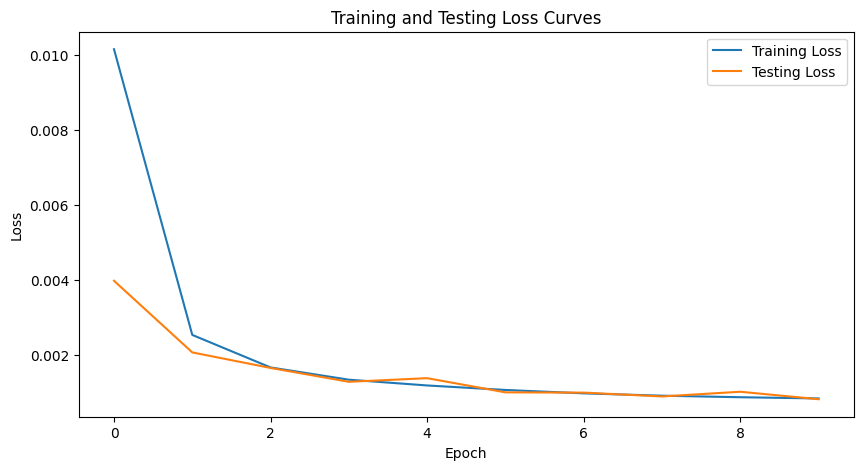

In [9]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
num_epochs = 10


def evaluate(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for batch in range(len(X_test)):
            hidden = model.initHidden().to(device)
            X_batch = X_test[batch].to(device)
            y_batch = y_test[batch].to(device)
            for t in range(seq_length):
                output, hidden = model(X_batch[t].view(1, 1), hidden) #TODO
            output = output.view(-1)
            loss = criterion(output, y_batch)
            total_loss += loss.item()
    return total_loss / len(X_test)


# Lists to store loss values
training_losses = []
testing_losses = []

# Training loop with evaluation
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    for batch in range(len(X_train)):
        hidden = model.initHidden().to(device)
        X_batch = X_train[batch].to(device)
        y_batch = y_train[batch].to(device)
        model.zero_grad()
        for t in range(seq_length):
            output, hidden = model(X_batch[t].view(1, 1), hidden) # TODO
        output = output.view(-1)

        loss = criterion(output, y_batch)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(X_train)
    training_losses.append(avg_train_loss)

    # Evaluate on test data
    avg_test_loss = evaluate(model, X_test, y_test, criterion)
    testing_losses.append(avg_test_loss)

    # Print average losses for the epoch
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
    )

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In case of lack of GPUs, you can load the trained model :

In [10]:
# save model to disk
# torch.save(model.state_dict(), "rnn_model.pt")
# model = RNN(input_size, hidden_size, output_size).to(device)
# model.load_state_dict(torch.load("rnn_model.pt"))

In [11]:
def predict_recursive(model, initial_sequence, num_predictions):
    model.eval()  # Set the model to evaluation mode
    predictions = []

    # Use the last seq_length values from the training data as initial input
    input_sequence = initial_sequence

    # Initialize the hidden state
    hidden = model.initHidden().to("cpu")
    model = model.to("cpu")
    input_sequence = input_sequence.to("cpu")

    # Iterate over the length of the sequence we want to predict
    for p in range(num_predictions):
        for t in range(seq_length):
            output, hidden = model(input_sequence[t].view(1, 1), hidden) # TODO
        input_sequence = torch.cat((input_sequence, output.view(1, 1)))
        # remvoe the first element
        input_sequence = input_sequence[1:]
        predictions += [output.item()]
    return predictions


predictions = predict_recursive(model, X_test[-24], 24)

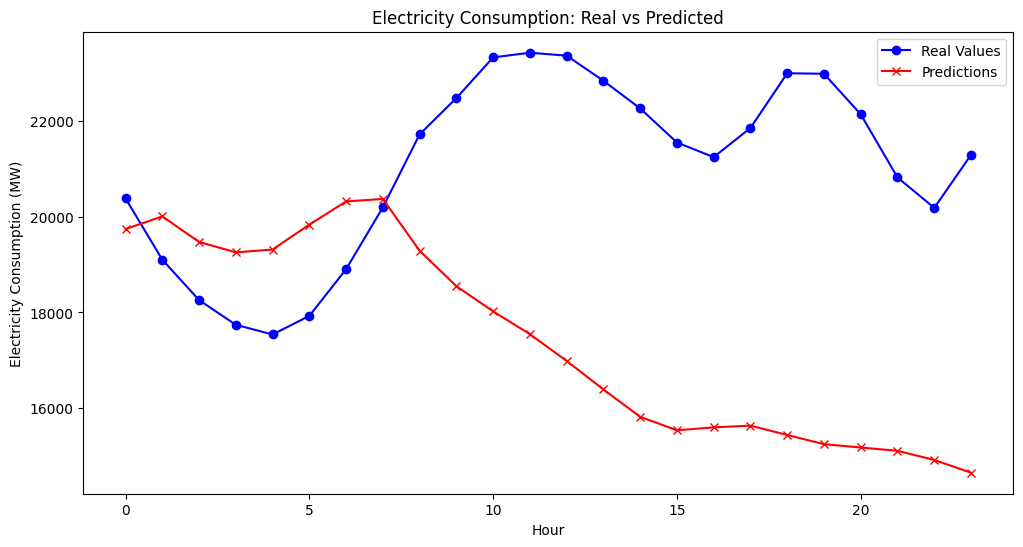

In [12]:
# Extract the real values for the last day from y_test
# Assuming y_test is already in the correct scale
real_values_last_day = y_test[-24:].cpu().numpy()
# unscale real_values_last_day
real_values_last_day = scaler.inverse_transform(real_values_last_day.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(real_values_last_day, label="Real Values", color="blue", marker="o")
plt.plot(predictions_rescaled, label="Predictions", color="red", marker="x")
plt.title("Electricity Consumption: Real vs Predicted")
plt.xlabel("Hour")
plt.ylabel("Electricity Consumption (MW)")
plt.legend()
plt.show()

In [19]:
preds = []
trues = []
for i, test_seq in enumerate(X_test):
  if y_test[i:(i+24)].shape[0] < 24:
    break
  preds.extend(predict_recursive(model, test_seq, 24))
  trues.extend(y_test[i:(i+24)].tolist())

preds = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
trues = scaler.inverse_transform(np.array(trues).reshape(-1, 1))

print("MAE", MAE()(torch.tensor(preds), torch.tensor(trues)))
print("SMAPE", SMAPE()(torch.tensor(preds), torch.tensor(trues)))

MAE tensor(2542.5276, dtype=torch.float64)
SMAPE tensor(0.1494, dtype=torch.float64)


## 2. LSTM in a univariate time series forecasting problem multi-output

Now it is you turn : Implement a LSTM directly with the LSTM module in pytorch in a multi-output strategy the next 24 hours in an uni-variate time series forecasting problem.

In [20]:
data = pd.read_csv(processed_filename)
# Convert 'Date - Heure' to datetime and set as index
data["Date - Heure"] = pd.to_datetime(data["Date - Heure"])
data.set_index("Date - Heure", inplace=True)

# select only "Île-de-France"
data_iledefrance = data[data["Région"] == "Île-de-France"]
# Focusing on the 'Consommation brute électricité (MW) - RTE' column
ts_data = data_iledefrance["Consommation brute électricité (MW) - RTE"]

scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))

In [21]:
def create_sequences(ts_scaled, input_len, prediction_len):
    """Create sequences of input_len from data. And return X and y with y being the next value after X."""
    X = []
    y = []

    for i in range(len(ts_scaled) - input_len - prediction_len):
        X.append(ts_scaled[i:i+input_len]) #TODO)
        y.append(ts_scaled[i+input_len: i+input_len+prediction_len]) #TODO)

    return np.array(X), np.array(y)


# Defining the sequence length (number of hours to use for prediction)
seq_length = 24  # using last 24 hours to predict the next hour
prediction_len = 24
X, y = create_sequences(ts_scaled, seq_length, prediction_len)

# Splitting the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

test_data = TensorDataset(X_test, y_test)
train_data = TensorDataset(X_train, y_train)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class LSTM(nn.Module):
    #TODO use the nn.LSTM module
    def __init__(self, output_size, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.output_size = output_size #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc = nn.Linear(hidden_size, output_size) #fully connected last layer

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        out = self.relu(hn[-1])
        out = self.fc(out) #Final Output
        return out


# TODO : Instantiate the model
input_size = 1
hidden_size = 64
output_size = 24
num_layers = 2

model = LSTM(output_size, input_size, hidden_size, num_layers, seq_length).to(device)


In [23]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
num_epochs = 10

Epochs:  10%|█         | 1/10 [00:03<00:35,  3.92s/it]

Epoch 1/10, Train Loss: 0.0009, Test Loss: 0.0003


Epochs:  20%|██        | 2/10 [00:08<00:34,  4.28s/it]

Epoch 2/10, Train Loss: 0.0003, Test Loss: 0.0002


Epochs:  30%|███       | 3/10 [00:12<00:29,  4.15s/it]

Epoch 3/10, Train Loss: 0.0002, Test Loss: 0.0002


Epochs:  40%|████      | 4/10 [00:19<00:31,  5.20s/it]

Epoch 4/10, Train Loss: 0.0002, Test Loss: 0.0002


Epochs:  50%|█████     | 5/10 [00:24<00:26,  5.25s/it]

Epoch 5/10, Train Loss: 0.0002, Test Loss: 0.0002


Epochs:  60%|██████    | 6/10 [00:28<00:18,  4.72s/it]

Epoch 6/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  70%|███████   | 7/10 [00:34<00:15,  5.17s/it]

Epoch 7/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  80%|████████  | 8/10 [00:38<00:09,  4.95s/it]

Epoch 8/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  90%|█████████ | 9/10 [00:45<00:05,  5.46s/it]

Epoch 9/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs: 100%|██████████| 10/10 [00:50<00:00,  5.04s/it]

Epoch 10/10, Train Loss: 0.0001, Test Loss: 0.0001


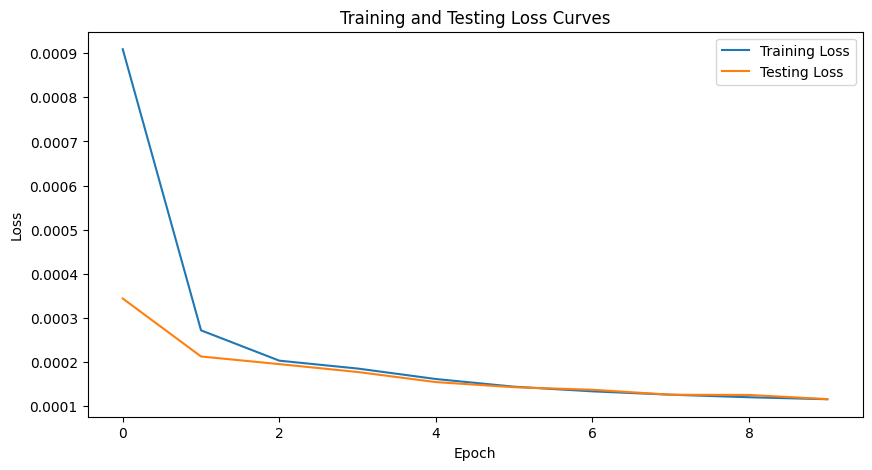

In [24]:
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.unsqueeze(-1), batch_y)
            total_loss += loss.item()

    return total_loss / len(X_test)

# Lists to store loss values
training_losses = []
testing_losses = []

# Training loop with evaluation
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs.unsqueeze(-1), batch_y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(X_train)
    training_losses.append(avg_train_loss)

    # Evaluate on test data
    avg_test_loss = evaluate(model, test_loader, criterion)
    testing_losses.append(avg_test_loss)

    # Print average losses for the epoch
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
    )

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
predictions = model(X_test[-1, :, :].unsqueeze(0).to(device))

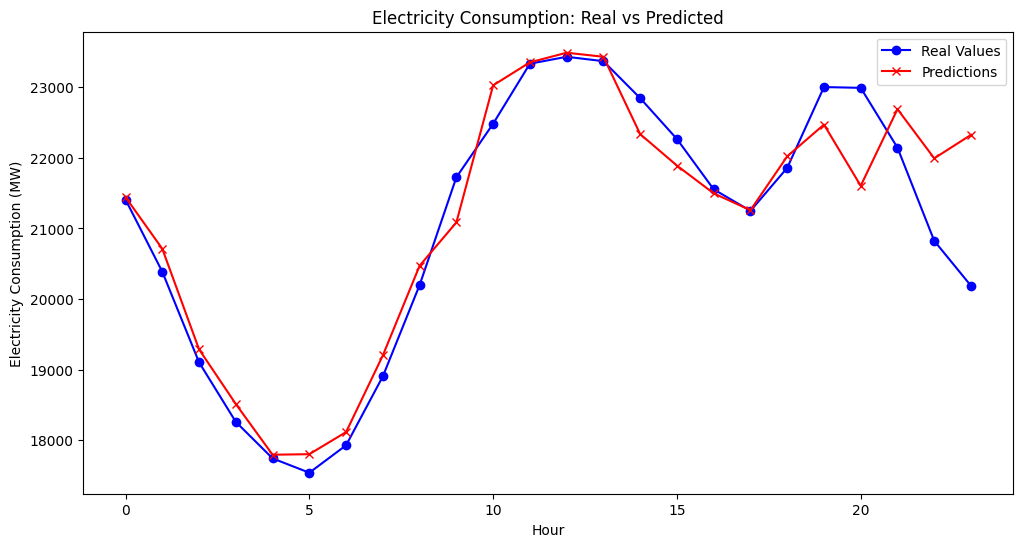

In [26]:
# Extract the real values for the last day from y_test
# Assuming y_test is already in the correct scale
real_values_last_day = y_test[-1, :, :].cpu().numpy()
# unscale real_values_last_day
real_values_last_day = scaler.inverse_transform(real_values_last_day.reshape(-1, 1))
predictions_rescaled = scaler.inverse_transform(predictions.cpu().detach().numpy().reshape(-1, 1))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(real_values_last_day, label="Real Values", color="blue", marker="o")
plt.plot(predictions_rescaled, label="Predictions", color="red", marker="x")
plt.title("Electricity Consumption: Real vs Predicted")
plt.xlabel("Hour")
plt.ylabel("Electricity Consumption (MW)")
plt.legend()
plt.show()

In [27]:
preds = model(X_test.to(device))
preds = scaler.inverse_transform(preds.flatten().cpu().detach().numpy().reshape(-1, 1))
trues = scaler.inverse_transform(y_test.squeeze(-1).flatten().cpu().detach().numpy().reshape(-1, 1))

print("MAE", round(MAE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))
print("SMAPE", round(SMAPE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))

MAE 1021.84
SMAPE 0.06


## 3. LSTM in a multivariate time series forecasting problem

Now it is you turn : Implement a LSTM directly with the LSTM module in pytorch in a multi-output strategy the next 24 hours in an multi-variate time series forecasting problem.
First try to incorporate the different features you have created in the previous notebook only for Ile-de-France.
Then prepare the data for the whole regions.

In [28]:
ts_data = data_iledefrance.drop(columns=["Région", "jour", "Température_norm", "Consumption_lag_day_1"])

scaler_x = MinMaxScaler()
ts_scaled = scaler_x.fit_transform(ts_data.iloc[:, 1:])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(ts_data.iloc[:, [0]])

ts_scaled = np.hstack((y_scaled, ts_scaled))

In [29]:
def create_sequences(ts_scaled, input_len, prediction_len):
    """Create sequences of input_len from data. And return X and y with y being the next value after X."""
    X = []
    y = []

    for i in range(len(ts_scaled) - input_len - prediction_len):
        X.append(ts_scaled[i:i+input_len, :]) #TODO)
        y.append(ts_scaled[i+input_len: i+input_len+prediction_len, 0]) #TODO)

    return np.array(X), np.array(y)


# Defining the sequence length (number of hours to use for prediction)
seq_length = 24  # using last 24 hours to predict the next hour
prediction_len = 24
X, y = create_sequences(ts_scaled, seq_length, prediction_len)

# Splitting the data into training and test sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

test_data = TensorDataset(X_test, y_test)
train_data = TensorDataset(X_train, y_train)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [30]:
# TODO : Instantiate the model
input_size = 17
hidden_size = 64
output_size = 24
num_layers = 2

model = LSTM(output_size, input_size, hidden_size, num_layers, seq_length).to(device)


In [31]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
num_epochs = 10

Epochs:  10%|█         | 1/10 [00:03<00:32,  3.59s/it]

Epoch 1/10, Train Loss: 0.0007, Test Loss: 0.0002


Epochs:  20%|██        | 2/10 [00:07<00:28,  3.57s/it]

Epoch 2/10, Train Loss: 0.0002, Test Loss: 0.0001


Epochs:  30%|███       | 3/10 [00:11<00:26,  3.82s/it]

Epoch 3/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  40%|████      | 4/10 [00:14<00:22,  3.72s/it]

Epoch 4/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  50%|█████     | 5/10 [00:18<00:18,  3.79s/it]

Epoch 5/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  60%|██████    | 6/10 [00:23<00:16,  4.09s/it]

Epoch 6/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  70%|███████   | 7/10 [00:27<00:11,  3.94s/it]

Epoch 7/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  80%|████████  | 8/10 [00:30<00:07,  3.83s/it]

Epoch 8/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs:  90%|█████████ | 9/10 [00:34<00:03,  3.81s/it]

Epoch 9/10, Train Loss: 0.0001, Test Loss: 0.0001


Epochs: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]

Epoch 10/10, Train Loss: 0.0000, Test Loss: 0.0001


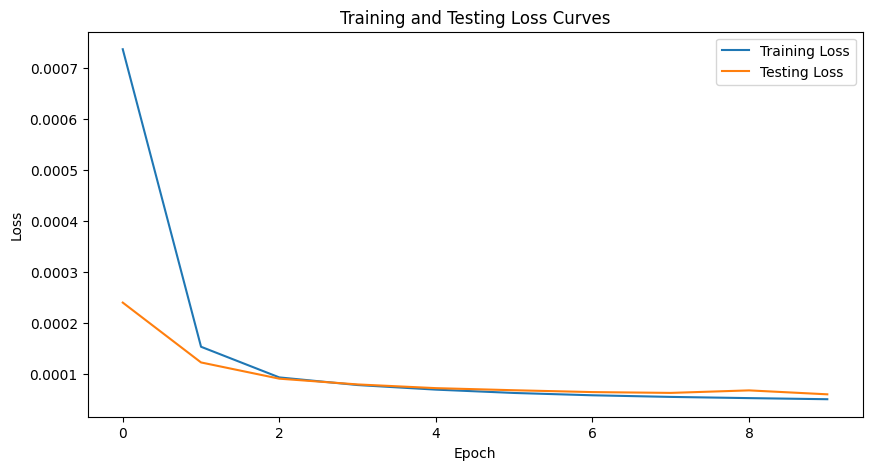

In [32]:
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            total_loss += loss.item()

    return total_loss / len(X_test)

# Lists to store loss values
training_losses = []
testing_losses = []

# Training loop with evaluation
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(X_train)
    training_losses.append(avg_train_loss)

    # Evaluate on test data
    avg_test_loss = evaluate(model, test_loader, criterion)
    testing_losses.append(avg_test_loss)

    # Print average losses for the epoch
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
    )

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
predictions = model(X_test[-1, :, :].unsqueeze(0).to(device))

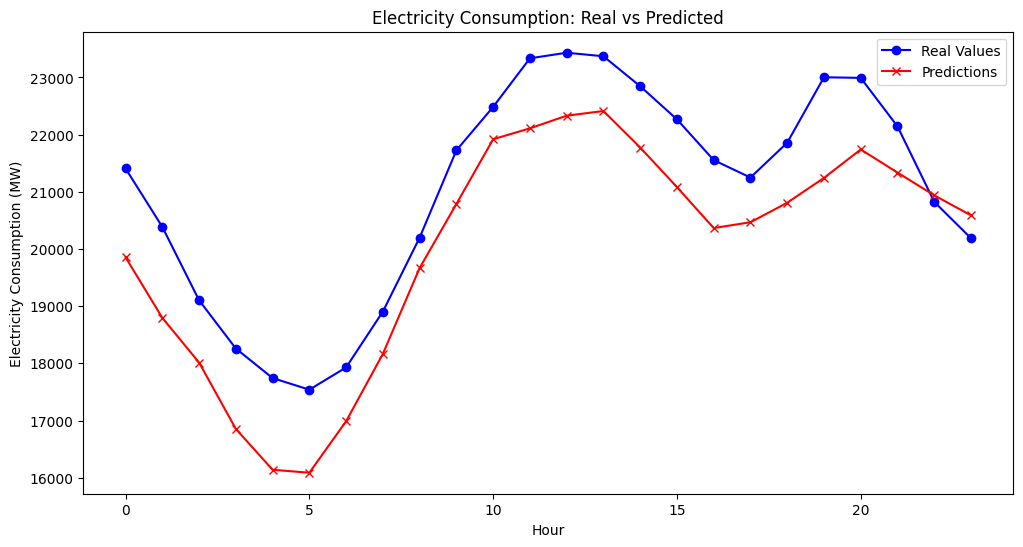

In [34]:
# Extract the real values for the last day from y_test
# Assuming y_test is already in the correct scale
real_values_last_day = y_test[-1, :].cpu().numpy()
# unscale real_values_last_day
real_values_last_day = scaler_y.inverse_transform(real_values_last_day.reshape(-1, 1))
predictions_rescaled = scaler_y.inverse_transform(predictions.cpu().detach().numpy().reshape(-1, 1))
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(real_values_last_day, label="Real Values", color="blue", marker="o")
plt.plot(predictions_rescaled, label="Predictions", color="red", marker="x")
plt.title("Electricity Consumption: Real vs Predicted")
plt.xlabel("Hour")
plt.ylabel("Electricity Consumption (MW)")
plt.legend()
plt.show()

In [35]:
preds = model(X_test.to(device))
preds = scaler.inverse_transform(preds.flatten().cpu().detach().numpy().reshape(-1, 1))
trues = scaler.inverse_transform(y_test.squeeze(-1).flatten().cpu().detach().numpy().reshape(-1, 1))

print("MAE", round(MAE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))
print("SMAPE", round(SMAPE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))

MAE 752.68
SMAPE 0.05


#### Region-agnostic model

In [36]:
ts_data = pd.concat([data.drop(columns=["Région", "jour", "Température_norm", "Consumption_lag_day_1"]), pd.get_dummies(data["Région"])], axis=1)
ts_data = ts_data.sort_index(axis=0)

scaler_x = MinMaxScaler()
ts_scaled = scaler_x.fit_transform(ts_data.iloc[:, 1:])

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(ts_data.iloc[:, [0]])

ts_scaled = np.hstack((y_scaled, ts_scaled))

In [37]:
def create_sequences_region(ts_scaled, input_len, prediction_len):
    """Create sequences of input_len from data. And return X and y with y being the next value after X."""
    X = []
    y = []

    for i in range(1, data['Région'].nunique() + 1):
      X_region = []
      y_region = []
      ts_scaled_region = ts_scaled[ts_scaled[:, -i] == 1, :]
      for i in range(len(ts_scaled_region) - input_len - prediction_len):
          X_region.append(ts_scaled_region[i:i+input_len, :]) #TODO)
          y_region.append(ts_scaled_region[i+input_len: i+input_len+prediction_len, 0]) #TODO)

      X.append(X_region)
      y.append(y_region)

    return X, y


# Defining the sequence length (number of hours to use for prediction)
seq_length = 24  # using last 24 hours to predict the next hour
prediction_len = 24
X, y = create_sequences_region(ts_scaled, seq_length, prediction_len)


In [38]:
X_train, X_test, y_train, y_test = [], [], [], []
for X_sub, y_sub in zip(X, y):
  # Splitting the data into training and test sets
  train_size = int(0.8 * len(X_sub))
  X_train.extend(X_sub[:train_size])
  X_test.extend(X_sub[train_size:])
  y_train.extend(y_sub[:train_size])
  y_test.extend(y_sub[train_size:])

In [39]:
X_train = np.dstack(X_train)
X_train = np.rollaxis(X_train, -1)

X_test = np.dstack(X_test)
X_test = np.rollaxis(X_test, -1)

y_test = np.dstack(y_test)
y_test = np.rollaxis(y_test, -1)

y_train = np.dstack(y_train)
y_train = np.rollaxis(y_train, -1)

In [40]:
# Converting to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

test_data = TensorDataset(X_test, y_test)
train_data = TensorDataset(X_train, y_train)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [41]:
# TODO : Instantiate the model
input_size = 29
hidden_size = 64
output_size = 24
num_layers = 2

model = LSTM(output_size, input_size, hidden_size, num_layers, seq_length).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
num_epochs = 10

Epochs:  10%|█         | 1/10 [01:05<09:48, 65.42s/it]

Epoch 1/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  20%|██        | 2/10 [02:08<08:33, 64.23s/it]

Epoch 2/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  30%|███       | 3/10 [03:11<07:24, 63.55s/it]

Epoch 3/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  40%|████      | 4/10 [04:15<06:21, 63.64s/it]

Epoch 4/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  50%|█████     | 5/10 [05:20<05:20, 64.04s/it]

Epoch 5/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  60%|██████    | 6/10 [06:23<04:15, 63.89s/it]

Epoch 6/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  70%|███████   | 7/10 [07:28<03:12, 64.24s/it]

Epoch 7/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  80%|████████  | 8/10 [08:32<02:08, 64.06s/it]

Epoch 8/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs:  90%|█████████ | 9/10 [09:37<01:04, 64.33s/it]

Epoch 9/10, Train Loss: 0.0000, Test Loss: 0.0000


Epochs: 100%|██████████| 10/10 [10:38<00:00, 63.88s/it]

Epoch 10/10, Train Loss: 0.0000, Test Loss: 0.0000


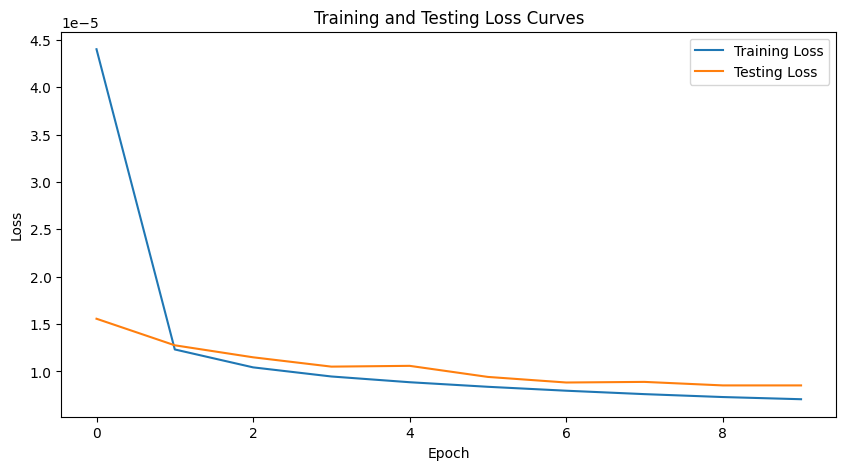

In [42]:
def evaluate(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track gradients
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs.unsqueeze(1), batch_y)
            total_loss += loss.item()

    return total_loss / len(X_test)


# Lists to store loss values
training_losses = []
testing_losses = []

# Training loop with evaluation
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = criterion(outputs.unsqueeze(1), batch_y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(X_train)
    training_losses.append(avg_train_loss)

    # Evaluate on test data
    avg_test_loss = evaluate(model, test_loader, criterion)
    testing_losses.append(avg_test_loss)

    # Print average losses for the epoch
    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}"
    )

# Plotting the training and testing loss curves
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(testing_losses, label="Testing Loss")
plt.title("Training and Testing Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [46]:
preds1 = model(X_test[:int(len(X_test)/2)].to(device))
preds2 = model(X_test[int(len(X_test)/2):].to(device))

In [55]:
preds = torch.cat((preds1, preds2), dim=0)

In [57]:
preds = scaler.inverse_transform(preds.flatten().cpu().detach().numpy().reshape(-1, 1))
trues = scaler.inverse_transform(y_test.squeeze(-1).flatten().cpu().detach().numpy().reshape(-1, 1))

print("MAE", round(MAE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))
print("SMAPE", round(SMAPE()(torch.tensor(preds), torch.tensor(trues)).item(), 2))

MAE 257.45
SMAPE 0.02
